<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction à la Recherche Opérationelle</h1><br/>M2 Statistique Science des Données (SSD)</center></td>
<td width=15%>
<a href="https://www-ljk.imag.fr/membres/Anatoli.Iouditski/" style="font-size: 16px; font-weight: bold">Anatoli Juditsky</a><br/>
<a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a> </td>
</tr>
</table>

<br/><br/>
<center><a style="font-size: 30pt; font-weight: bold">TP 3 - Moindres Carrés Positifs </a></center>
<br/><br/>

# 1- Problème de régression positive

On considère le modèle de régression normale
$$ y=X\theta+\sigma\xi,\;\;\xi\sim \mathcal{N}(0, I_m),$$
où  $X\in \mathbb{R}^{m\times n}$ et $y\in \mathbb{R}^m$ sont les observables, et $\theta\in \mathbb{R}_+^n$ est le paramètre inconnu.

Dans les moindres carrés positifs, on modélise $\theta$ comme un vecteur à valeurs positives et donc on ne cherche que les solutions positives du problème des moindres carrés. On veut donc résoudre le problème d'optimisation:
$$\tag{P1} \min_{\theta\in  \mathbb{R}^n} \|X\theta-y\|_2^2,~~\;\text{sous contrainte}\;\theta\geq0.$$



In [4]:
# Import des bibliothèques
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exemple de données pour tester votre code

In [5]:
# Exemple jouet
n = 10
m = 20
sigma = 0.1

# Reproductibilité
np.random.seed(42)

# Simulation de X, theta et xi
X = np.random.randn(m,n)
theta_true = np.random.rand(n)
xi = np.random.randn(m)

# Calcul de y
y = np.dot(X,theta_true) + sigma*xi

# 2- Résolution du problème



> **Question:** Écrivez une fonction qui résoud le problème (P1) de régression positive à partir de `X` et `y`. Testez la sur l'exemple ci-dessus.

In [6]:
def probleme_P1(X,y,verbose=False):
    """
    Fonction permettant de résoundre le problème (P1) : 
    ||X*theta -y||^2_2, avec la contrainte theta >=0 pour un X et un y donnés.

    Args:
        X (numpy.ndarray): Matrice de taille m*n
        y (numpy.ndarray): Vecteur de taille m
    Returns:
        _type_: _description_
    """
    
    # Initialisation de la variable a obtenir
    theta = cp.Variable(n) 
    # Definition de la fonction a minimiser
    L = cp.norm(X@theta - y, 2)**2
    objective = cp.Minimize(L)
    # Definition de la contrainte de positivite sur theta
    contrainte_positivite = theta >=0
    # Definition du probleme
    prob = cp.Problem(objective,[contrainte_positivite])
    # Resolution
    prob.solve(verbose=verbose)
    # Recuperation valeurs resultats
    theta_estim = theta.value
    residuals = y - X@theta_estim
    status = prob.status
    erreur = np.linalg.norm(residuals,np.inf)
    valeur_probleme = L.value
    
    return theta_estim,residuals,status,erreur,valeur_probleme
    

Testons la fonction probleme_P1 sur l'exemple jouet simulé précèdemment.

In [7]:
def pretty_result(theta_true,theta_estim,residuals,status,erreur,valeur_probleme):
    """_summary_

    Args:
        theta_estim (_type_): _description_
        residuals (_type_): _description_
        status (_type_): _description_
        erreur (_type_): _description_
        valeur_probleme (_type_): _description_
    """
    print(f"Le statut de l'estimation est : {status}.\n")
    print(f"La véritable valeur de theta est :\n{theta_true}\net la valeur estimée par la fonction est :\n{theta_estim}.\n")
    # Residus
    print(f"Les résidus sont :\n{residuals}.\n")
    # Erreur point par point
    diff = np.abs(theta_estim - theta_true)
    print(f"L'erreur maximale pour une coordonnée est {diff.max():.4f} et la différence moyenne est de {diff.mean():.4f}.\n")
    # Erreur globale
    print(f"La norme infinie du vecteur des résidus est de {erreur:.4f}.\n")
    # Valeur du problème
    print(f"La valeur du problème qui a été minimisée est de {valeur_probleme:.4f}.")
    
    

In [8]:
# Recuperation du resultat
theta_estim,residuals,status,erreur,valeur_probleme = probleme_P1(X,y)

In [9]:
pretty_result(theta_true,theta_estim,residuals,status,erreur,valeur_probleme)

Le statut de l'estimation est : optimal.

La véritable valeur de theta est :
[0.87737307 0.74076862 0.69701574 0.70248408 0.35949115 0.29359184
 0.80936116 0.81011339 0.86707232 0.91324055]
et la valeur estimée par la fonction est :
[0.87261568 0.70924758 0.7268764  0.69226131 0.31171535 0.30562895
 0.74405455 0.7888229  0.78387326 0.93156694].

Les résidus sont :
[ 0.10783935  0.1568446  -0.09877538  0.07046946  0.09604031  0.06734885
  0.06221598  0.05148585 -0.1357876   0.05343121  0.07062356  0.06293893
  0.09278838 -0.1857302   0.09289198 -0.08309076  0.05851774  0.04792567
 -0.01331059 -0.1270557 ].

L'erreur maximale pour une coordonnée est 0.0832 et la différence moyenne est de 0.0324.

La norme infinie du vecteur des résidus est de 0.1857.

La valeur du problème qui a été minimisée est de 0.1822.


### Pourquoi est-ce qu'on ajoute une contrainte pour la stabilité ?  Qu'est-ce que ça apporte ?

# 3- Ajout de contraintes

Afin d'améliorer la stabilité du modèle, on décide d'ajouter la contrainte que la somme des valeurs de theta ne doit pas dépasser une constante $S$. le problème devient alors
$$\tag{P2} \min_{\theta\in  \mathbb{R}^n} \|X\theta-y\|_2^2,~~~\;\text{sous contrainte}\;\theta\geq0 \text{ et } \sum_{i=1}^n \theta_i \leq S.$$



> **Question:** Écrivez une fonction qui résoud le problème (P2) à partir de `X`, `y`, et `S`. Testez la sur l'exemple ci-dessus avec $S=1$.

In [10]:
def probleme_P2(X,y,S,verbose=False):
    """
    Fonction permettant de résoundre le problème (P2) : 
    ||X*theta -y||^2_2, avec la contrainte theta >=0 et la contrainte sum(theta)<=S pour un X, un y et un S donnés.

    Args:
        X (numpy.ndarray): Matrice de taille m*n
        y (numpy.ndarray): Vecteur de taille m
        S (int,float) : La valeur contraingant la somme des coefficients de theta.
    Returns:
        _type_: _description_
    """
    
    # Initialisation de la variable a obtenir
    theta = cp.Variable(n) 
    # Definition de la fonction a minimiser
    L = cp.norm(X@theta - y, 2)**2
    objective = cp.Minimize(L)
    # Definition de la contrainte de positivite sur theta
    contrainte_positivite = theta >=0
    contrainte_stabilite = sum(theta)<=S
    # Definition du probleme
    prob = cp.Problem(objective,[contrainte_positivite,contrainte_stabilite])
    # Resolution
    prob.solve(verbose=verbose)
    # Recuperation valeurs resultats
    theta_estim = theta.value
    residuals = y - X@theta_estim
    status = prob.status
    erreur = np.linalg.norm(residuals,np.inf)
    valeur_probleme = L.value
    
    return theta_estim,residuals,status,erreur,valeur_probleme

Test de l'exemple :

In [11]:
S=1
theta_estim,residuals,status,erreur,valeur_probleme = probleme_P2(X,y,S)
pretty_result(theta_true,theta_estim,residuals,status,erreur,valeur_probleme)

Le statut de l'estimation est : optimal.

La véritable valeur de theta est :
[0.87737307 0.74076862 0.69701574 0.70248408 0.35949115 0.29359184
 0.80936116 0.81011339 0.86707232 0.91324055]
et la valeur estimée par la fonction est :
[ 1.35814280e-09 -5.08633842e-10  8.44282938e-09  2.39849397e-01
  2.37735034e-09 -8.38447374e-11  1.91536174e-01  4.91203522e-08
 -6.24143444e-10  5.68614370e-01].

Les résidus sont :
[ 2.76532371 -3.51320485 -0.62751979 -2.14603232  0.16963626  0.37387476
 -0.36400938  0.73686568  0.89633756 -0.11450848 -0.64691945 -0.21215064
  0.27729552 -2.35689604 -0.75460592  0.57413171  2.14807263  1.06406733
 -1.49642141 -0.8818143 ].

L'erreur maximale pour une coordonnée est 0.8774 et la différence moyenne est de 0.6071.

La norme infinie du vecteur des résidus est de 3.5132.

La valeur du problème qui a été minimisée est de 42.4072.


Commentaire sur la différence en faisant le choix de S=1.
- Norme infinie + grande
- Valeur du problème + grande
- chiffres négatifs (même si virtuellement égaux à 0) dans theta estimé
- l'estimation ne fait pas trop de sens, toutes les valeurs sont très différentes

> **Question:** Faites varier $S$. Est-ce que la valeur du problème change? Est-ce que la solution change? Est-ce que le problème reste faisable?

- Valeur du problème -> valeur de L, valeur qui a été minimisée
- Solution du problème -> valeur de theta, valeur qui permet la minimisation
- Faisabilité du problème -> statut optimal ?

In [12]:
def solutions(X,y,S_vals):
    """_summary_

    Args:
        X (_type_): _description_
        y (_type_): _description_
        S_vals (_type_): _description_

    Returns:
        _type_: _description_
    """
    problem_vals = []
    solution_vals = []
    status_vals = []
    for S in S_vals:
        theta_estim,_,status,_,valeur_probleme = probleme_P2(X,y,S)
        problem_vals.append(valeur_probleme)
        solution_vals.append(theta_estim)
        status_vals.append(status)
    return problem_vals,solution_vals,status_vals

In [13]:
S_vals = np.linspace(0.001,10,1000)
problem_vals,solution_vals,status_vals = solutions(X,y,S_vals)

c:\Users\garan\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Evolution de la valeur du problème L selon la valeur de S

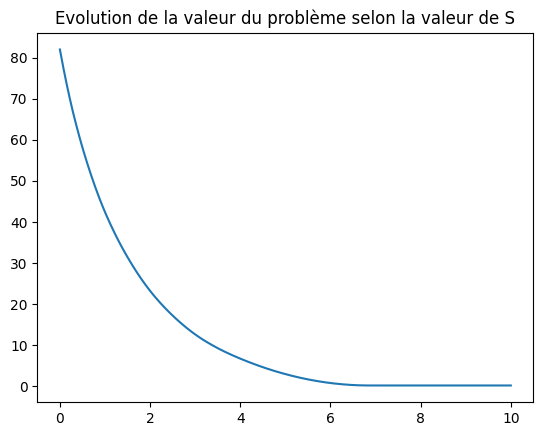

In [14]:
plt.plot(S_vals,problem_vals)
plt.title("Evolution de la valeur du problème selon la valeur de S")
plt.show()
# Notes : mettre l'abscisse en ln ?

### Evolution de la solution theta

In [15]:
# Est-ce que la solution change ???
# Trouve un moyen de visualiser cela, peut-être avec l'erreur ou les coefficients ?

1. Evolution de l'erreur

In [16]:
def difference(solutions,theta_estim):
    res = []
    for solution in solutions :
        res.append(np.linalg.norm(solution-theta_estim,np.inf))
    return res

In [17]:
erreur_vals = difference(solution_vals,theta_true)

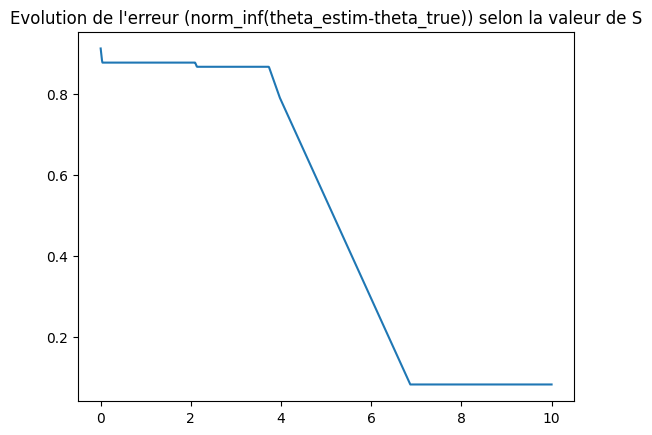

In [18]:
# Visualisation
plt.plot(S_vals,erreur_vals)
plt.title("Evolution de l'erreur (norm_inf(theta_estim-theta_true)) selon la valeur de S")
plt.show()

2. Evolution de la valeur maximale de theta_estim et de la valeur minimale de thete_estim selon S

In [19]:
def min_max(solutions):
    max_list = []
    min_list = []
    for solution in solutions :
        max_list.append(max(solution))
        min_list.append(min(solution))
    return min_list,max_list

In [20]:
min_vals,max_vals = min_max(solution_vals)

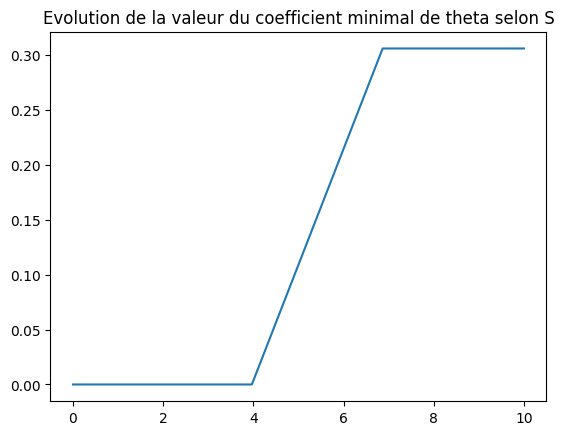

In [21]:
plt.plot(S_vals,min_vals)
plt.title("Evolution de la valeur du coefficient minimal de theta selon S")
plt.show()

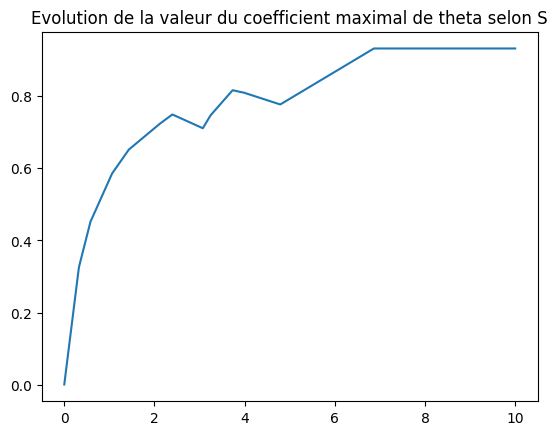

In [22]:
# Visualisation
plt.plot(S_vals,max_vals)
plt.title("Evolution de la valeur du coefficient maximal de theta selon S")
plt.show()

### Faisabilité

In [23]:
# Est-ce que le problème reste faisable ?
status_vals.index('optimal_inaccurate')

24

Une valeur problématique où on a pas tout à fait l'optimalité avec un S très faible.

To continue

### Convergence de P2 vers P1 lorsque S devient grand

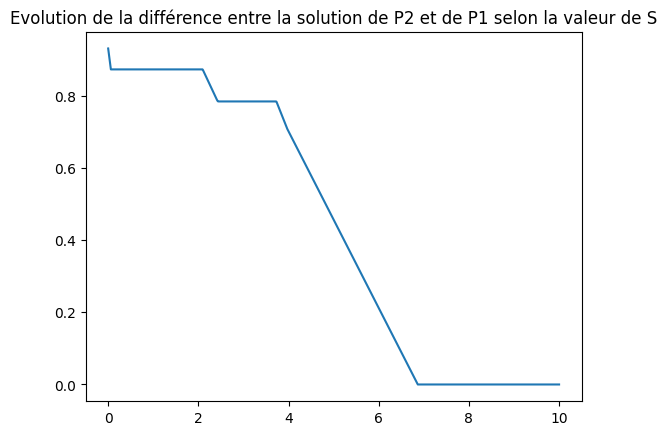

In [24]:
# Montrer la convergence de P2 vers P1 lorsque S est grand

theta_estim,residuals,status,erreur,valeur_probleme = probleme_P1(X,y) # Solution de P1
difference_P1_P2 = difference(solution_vals,theta_estim)

# Visualisation
plt.plot(S_vals,difference_P1_P2)
plt.title("Evolution de la différence entre la solution de P2 et de P1 selon la valeur de S")
plt.show()

# 4- Observation des variables duales

> **Question:** Écrivez une fonction qui résoud le problème (P2) à partir de `X`, `y`, et `S` et qui retourne la solution ainsi que les variables duales du problème

In [25]:
def probleme_P2_dual(X,y,S,verbose=False):
    """
    Fonction permettant de résoundre le problème (P2) : 
    ||X*theta -y||^2_2, avec la contrainte theta >=0 et la contrainte sum(theta)<=S pour un X, un y et un S donnés.
    Retourne les valeurs duales

    Args:
        X (numpy.ndarray): Matrice de taille m*n
        y (numpy.ndarray): Vecteur de taille m
        S (int,float) : La valeur contraingant la somme des coefficients de theta.
    Returns:
        _type_: _description_
    """
    
    # Initialisation de la variable a obtenir
    theta = cp.Variable(n) 
    # Definition de la fonction a minimiser
    L = cp.norm(X@theta - y, 2)**2
    objective = cp.Minimize(L)
    # Definition de la contrainte de positivite sur theta
    contrainte_positivite = theta >=0
    contrainte_stabilite = sum(theta)<=S
    # Definition du probleme
    prob = cp.Problem(objective,[contrainte_positivite,contrainte_stabilite])
    # Resolution
    prob.solve(verbose=verbose)
    # Recuperation valeurs resultats
    theta_estim = theta.value
    residuals = y - X@theta_estim
    status = prob.status
    erreur = np.linalg.norm(residuals,np.inf)
    valeur_probleme = L.value
    dual_positivite= prob.constraints[0].dual_value
    dual_stabilite = prob.constraints[1].dual_value
    
    return theta_estim,residuals,status,erreur,valeur_probleme,dual_positivite,dual_stabilite

In [26]:
theta_estim,residuals,status,erreur,valeur_probleme,dual_positivite,dual_stabilite = probleme_P2_dual(X,y,1)

In [27]:
dual_positivite

array([1.49193105e+01, 2.75123289e+01, 5.43461596e+00, 2.57401190e-07,
       1.33766843e+01, 2.59531576e+01, 3.21792093e-07, 1.13440261e+00,
       2.22121584e+01, 1.08127797e-07])

In [28]:
dual_stabilite

25.796662391519494

Rappel : plus la valeur duale est grande + la condition est difficile à respecter.

> **Question:** Pour différentes valeurs de $S$, observez quelles sont les contraintes actives et non-actives. Mettez en relation vos observations avec la valeur de la solution.

In [34]:
def solutions_dual(X,y,S_vals):
    """_summary_

    Args:
        X (_type_): _description_
        y (_type_): _description_
        S_vals (_type_): _description_

    Returns:
        _type_: _description_
    """
    dual_positivite_vals = []
    dual_stabilite_vals = []
    valeur_probleme_vals = []
    for S in S_vals:
        _,_,_,_,valeur_probleme,dual_positivite,dual_stabilite = probleme_P2_dual(X,y,S)
        dual_positivite_vals.append(dual_positivite)
        dual_stabilite_vals.append(dual_stabilite)
        valeur_probleme_vals.append(valeur_probleme)
    return valeur_probleme_vals,dual_positivite_vals,dual_stabilite_vals

Recupération des résultats

In [35]:
S_vals = np.linspace(0.001,10,10000)
valeur_probleme_vals,dual_positivite_vals,dual_stabilite_vals = solutions_dual(X,y,S_vals)

c:\Users\garan\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Evolution des valeurs maximales et minimales des duals associés à la contrainte de positivité selon S

In [37]:
min_vals_dual,max_vals_dual= min_max(dual_positivite_vals)

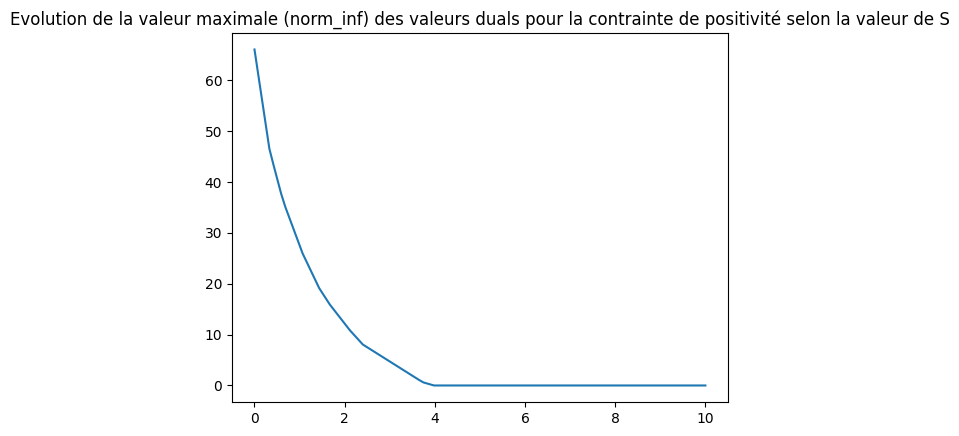

In [38]:
plt.plot(S_vals,max_vals_dual)
plt.title("Evolution de la valeur maximale (norm_inf) des valeurs duals pour la contrainte de positivité selon la valeur de S")
plt.show()

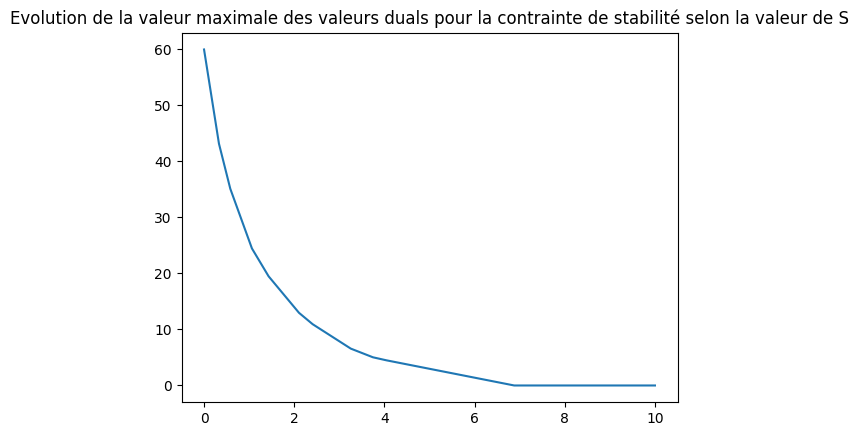

In [39]:
plt.plot(S_vals,dual_stabilite_vals)
plt.title("Evolution de la valeur maximale des valeurs duals pour la contrainte de stabilité selon la valeur de S")
plt.show()

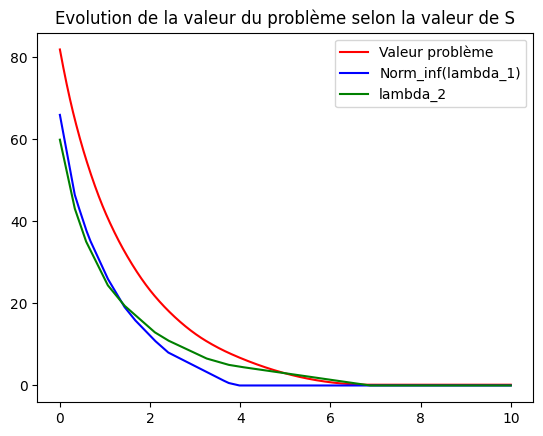

In [45]:
plt.plot(S_vals,valeur_probleme_vals,color="red",label="Valeur problème")
plt.plot(S_vals,max_vals_dual,color="blue",label="Norm_inf(lambda_1)")
plt.plot(S_vals,dual_stabilite_vals,color="green",label="lambda_2")
plt.legend()
plt.title("Evolution de la valeur du problème selon la valeur de S")
plt.show()

On voit appraitre une valeur de S spécifique autour de 7 
- Point où on nobserve plus d'évolution de la valeur du problème
- Point où l'erreur ie norm_inf entre theta_estimé et theta_true devient minimale et n'évolue plus
- Point où le norminf(theta) n'évolue plus
- Point où la valeur dual vis à vis de la contrainte de stabilité n'evolue plus
- C'est le moment où P2 est concrètement égal à P1
-> C'est le moment où la contrainte de stabilité S n'a plus d'influence sur la solution. La solution optimale n'est pas "bloquée" par S.
